# Burst Fitting example using BurstFit class

In [1]:
from burstfit.fit import BurstFit
from burstfit.data import BurstData
from burstfit.model import Model, SgramModel
from burstfit.utils.plotter import plot_me
from burstfit.utils.functions import pulse_fn_vec, sgram_fn_vec, gauss_norm, gauss_2d
from burstfit.io import BurstIO
import logging
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
logging_format = "%(asctime)s - %(funcName)s -%(name)s - %(levelname)s - %(message)s"
logging.basicConfig(
    level=logging.INFO,
    format=logging_format,
)

## Get candidate cutout and preprocess

We will use `BurstData` class for this. It will crop the relevant time window. Dedisperse the data. Normalise the data to zero mean and unit standard deviation. Apply RFI masks (if any) and RFI filtering (if activated). 

In [3]:
#fil_file = '../tests/data/tcand_2_dm_565.30000_snr_11.92560.fil' # test data provided
#fil_file = '/data/dsa110/T1/corr02/2021_9_19_23_15_35/fil_210920aaai/210920aaai_98.fil' # our data (beam 98)
#fil_file = "/home/ubuntu/gechen/fake_data/test_1beams_10s.fil"
#fil_file='/data/dsa110/T1/corr09/2021_10_8_0_29_27/fil_211009aacy/211009aacy_175.fil'

fil_file='/data/dsa110/T1/corr02/2021_10_31_23_21_15/fil_211101aaly/211101aaly_79.fil'
save_name = '211101aaly_79'

In [4]:
# # fil_211009aacy 
# bd = BurstData(
#     fp=fil_file,
#     dm=56.2,
#     tcand=0.5, # pulse starting time in s.
#     width=4, # width = 4 or 2^4 in time sample?  
#     snr=27.0, 
#     #kill_mask=np.array([False]),
#     #min_samp=4./256-6
# )


# 211101aaly_79
bd = BurstData(
    fp=fil_file,
    dm=59.4,
    tcand=0.5, # pulse starting time in s.
    width=32, # width = 4 or 2^4 in time sample?  
    snr=26.3, 
    #kill_mask=np.array([False]),
    #min_samp=4./256-6
)

In [5]:
bd.prepare_data(time_window=0.1) #time_window=0.2s, mask_chans=[(0, 180), (900,1100)],normalise=True

2021-11-11 19:22:32,699 - prepare_data -burstfit.data - INFO - Preparing data for burst fitting.
2021-11-11 19:22:33,045 - crop_dedispersed_data -burstfit.data - INFO - Cropping data with time_window: 0.1s.
2021-11-11 19:22:33,047 - normalise_data -burstfit.data - INFO - Normalising data using off pulse mean and std.
2021-11-11 19:22:33,127 - normalise_data -burstfit.data - INFO - Off pulse mean and std are: (35.72514343261719, 21.280158634553185)


Using <class 'str'>:
/data/dsa110/T1/corr02/2021_10_31_23_21_15/fil_211101aaly/211101aaly_79.fil

## Fitting using BurstFit

In `BurstFit`, the fitting procedure for each component is as follows: 
1. Fit the profile using `curve_fit` and a profile model
2. Find the spectra using profile fit parameters
3. Fit the spectra using `curve_fit` and spectra model 
4. Use the profile and spectra fit parameters as initial guess and fit the 2D spectrogram using `curve_fit` and spectrogram model 

Therefore, `BurstFit` requires three functions: profile function, spectra function and spectrogram function. It is assumed that spectrogram function will use profile and spectra functions to make the spectrogram.   

Use the `Model` class to make profile and spectra models. You can optionally give names of the input parameters. These parameter names are used by `BurstFit` to automatically set relevant fitting bounds and priors.  

In [6]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
#sys.path.insert(1, '/home/ubuntu/proj/dsa110-shell/dsa110-T3/dsaT3/')
# import filplot_funcs as ff

sys.path.insert(1, '/home/ubuntu/gechen/software')
import filplot_funcs_gc as ff

/home/ubuntu/gechen/software/filplot_funcs_gc.py:20: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import inset_axes
2021-11-11 19:22:35,956 - _logit -dsaStore - INFO - {"mjd": 59529.80736060034, "proj": "dsa", "subsystem": "System", "app": "_", "version": "_", "module": "dsaStore", "function": "_check_host", "level": "info", "time": "2021-11-11T19:22:35.955859Z", "msg": "TODO: implement"}
2021-11-11 19:22:35,957 - _logit -dsaStore - INFO - {"mjd": 59529.807360619816, "proj": "dsa", "subsystem": "System", "app": "_", "version": "_", "module": "dsaStore", "function": "_check_port", "level": "info", "time": "2021-11-11T19:22:35.957544Z", "msg": "TODO: implement"}
2021-11-11 19:22:35,960 - _logit -dsaStore - INFO - {"mjd": 59529.80736065138, "proj"

Secrets not found. Cannot use datacite API


2021-11-11 19:22:36,602 - _logit -dsaStore - INFO - {"mjd": 59529.807368078335, "proj": "dsa", "subsystem": "System", "app": "_", "version": "_", "module": "dsaStore", "function": "_check_host", "level": "info", "time": "2021-11-11T19:22:36.601954Z", "msg": "TODO: implement"}
2021-11-11 19:22:36,604 - _logit -dsaStore - INFO - {"mjd": 59529.80736810154, "proj": "dsa", "subsystem": "System", "app": "_", "version": "_", "module": "dsaStore", "function": "_check_port", "level": "info", "time": "2021-11-11T19:22:36.603962Z", "msg": "TODO: implement"}
2021-11-11 19:22:36,606 - _logit -dsaStore - INFO - {"mjd": 59529.80736812446, "proj": "dsa", "subsystem": "System", "app": "_", "version": "_", "module": "dsaStore", "function": "c-tor", "level": "info", "time": "2021-11-11T19:22:36.605945Z", "msg": "DsaStore created"}
2021-11-11 19:22:36,609 - _logit -Conf - INFO - {"mjd": 59529.807368157926, "proj": "dsa", "subsystem": "System", "app": "_", "version": "_", "module": "Conf", "function": "_ch

### fit for DM in high-rsolution DM-time plot 

In [7]:
data, datadm, tsdm0, dms, datadm0 = ff.proc_cand_fil(fil_file, bd.dm, bd.width, nfreq_plot=256, ndm=512) 

In [70]:
print(np.shape(datadm))

(128, 15258)


In [75]:
downsample = 1 # bd.width 
data_dm0 = ff.read_fil_data_dsa(fil_file, 0, int(1.0/bd.tsamp))[0]
datadm, dms= ff.dm_transform(data_dm0, dm_min=-50, dm_max=100, dm0=bd.dm, ndm=512, freq_ref=None, downsample=downsample) #data = filplot_func.read_fil_data_dsa(fn_fil, 0, 1024)


In [94]:
datadm_flip = np.flip(datadm, axis=0)
print(np.shape(datadm_flip))
#print(dms)
# 4/bd.tsamp

(512, 3814)


In [95]:
def extract_datadm(data_2d, t_min, t_max, dm_min, dm_max):
    x_low, x_high = (int(t_min*1e-3/bd.tsamp), int(t_max*1e-3/bd.tsamp)+1) 
    y_low, y_high = (np.where(dms > dm_min)[0][0], np.where(dms < dm_max)[0][-1]+1)
    region_x, region_y = np.meshgrid(range(x_low, x_high), range(y_low, y_high)) 
    region = np.dstack((region_x, region_y))
    
    #extent = 1e3*x_low * bd.tsamp, 1e3*x_high * bd.tsamp, dms[y_high], dms[y_low] 
    extent = 1e3*x_low * bd.tsamp, 1e3*x_high * bd.tsamp, dms[y_low], dms[y_high]
    xdata = (region_x, region_y)
    ydata = data_2d[y_low: y_high, x_low: x_high]

    return xdata, ydata, extent 



In [101]:
t_min, t_max = 480, 540 # ms
dm_min, dm_max = 20, 80 #bd.dm-50, bd.dm+50 
xdata, ydata, extent = extract_datadm(datadm_flip, t_min, t_max, dm_min, dm_max)

print(np.shape(datadm_flip))
print(np.shape(ydata))

(512, 3814)
(205, 229)


In [106]:
from scipy.optimize import curve_fit

# amplitude, x0, y0, sigma_x, sigma_y, offset, theta
initial_guess = (np.max(datadm), 0.51/bd.tsamp, bd.dm, 5, 5, np.mean(datadm), -np.pi/4) 
popt_2d, pcov_2d = curve_fit(gauss_2d, xdata, ydata.ravel(), p0=initial_guess) 

datadm_amp, datadm_t0, datadm_dm, datadm_sigma_t0, datadm_sigma_dm, datadm_offset, datadm_theta = popt_2d
datadm_amp_err, datadm_t0_err, datadm_dm_err, datadm_sigma_t0_err, datadm_sigma_dm_err, datadm_offset_err, datadm_theta_err = [pcov_2d[i][i] for i in range(np.shape(pcov_2d)[0])]   


print('p0:', initial_guess)
print('\nResult:', popt_2d) 
print(pcov_2d)
print('DM: {:3.2f} \pm {:3.2f}'.format(datadm_dm, datadm_dm_err))

/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


p0: (36.7646484375, 1945.49560546875, 59.4, 5, 5, 35.72996920269075, -0.7853981633974483)

Result: [ 3.67646484e+01  1.94549561e+03  5.94000000e+01  5.00000000e+00
  5.00000000e+00  3.57988990e+01 -7.85398163e-01]
[[inf inf inf inf inf inf inf]
 [inf inf inf inf inf inf inf]
 [inf inf inf inf inf inf inf]
 [inf inf inf inf inf inf inf]
 [inf inf inf inf inf inf inf]
 [inf inf inf inf inf inf inf]
 [inf inf inf inf inf inf inf]]
DM: 59.40 \pm inf


In [111]:
fit_2d_result = gauss_2d(xdata, popt_2d[0], popt_2d[1], popt_2d[2], popt_2d[3], popt_2d[4], popt_2d[5], popt_2d[6]).reshape(ydata.shape)

print(np.shape(datadm))
datadm_dm, datadm_dm_err

fit_2d_result

(512, 3814)


array([[35.79889898, 35.79889898, 35.79889898, ..., 35.79889898,
        35.79889898, 35.79889898],
       [35.79889898, 35.79889898, 35.79889898, ..., 35.79889898,
        35.79889898, 35.79889898],
       [35.79889898, 35.79889898, 35.79889898, ..., 35.79889898,
        35.79889898, 35.79889898],
       ...,
       [35.79889898, 35.79889898, 35.79889898, ..., 35.79889898,
        35.79889898, 35.79889898],
       [35.79889898, 35.79889898, 35.79889898, ..., 35.79889898,
        35.79889898, 35.79889898],
       [35.79889898, 35.79889898, 35.79889898, ..., 35.79889898,
        35.79889898, 35.79889898]])

Text(0, 0.5, 'DM')

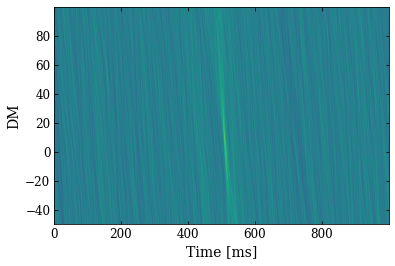

In [104]:
#%matplotlib notebook
%matplotlib inline

extent0 = 0, np.shape(datadm)[1]*bd.tsamp*1e3, dms[0], dms[-1]

fig0, ax0 = plt.subplots()
im0 = ax0.imshow(datadm_flip, extent=extent0, aspect='auto')
ax0.set_xlabel('Time [ms]')
ax0.set_ylabel('DM')
#fig0.savefig(save_name+'_datadm.pdf') 


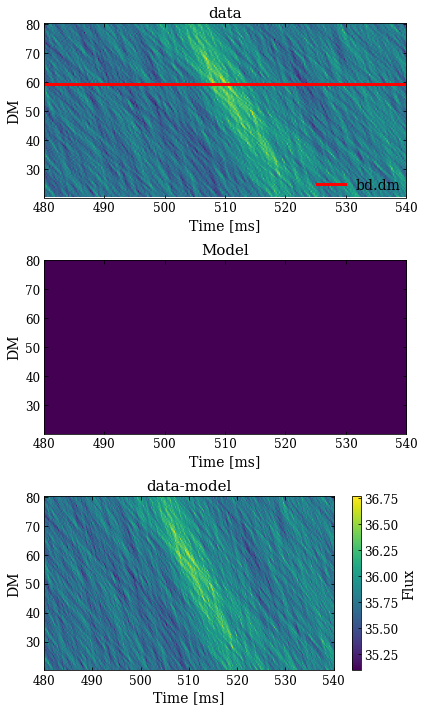

In [105]:
fig1, ax1 = plt.subplots(3, 1, figsize=(6,10))

im0 = ax1[0].imshow(ydata, extent=extent, aspect='auto')
ax1[0].axhline(y = bd.dm, c='r', lw='3', label='bd.dm')
ax1[0].legend()
ax1[0].set_xlabel('Time [ms]')
ax1[0].set_ylabel('DM')
ax1[0].set_title('data')

#im_ratio = ydata.shape[1]/ydata.shape[0] 
#cbar = plt.colorbar(im1, fraction=0.046*im_ratio, pad=0.04)
cbar = plt.colorbar(im0)
cbar.set_label('Flux')


im1 = ax1[1].imshow(fit_2d_result, extent=extent, aspect='auto')
ax1[1].set_xlabel('Time [ms]')
ax1[1].set_ylabel('DM')
ax1[1].set_title('Model')

im2 = ax1[2].imshow(ydata - fit_2d_result, extent=extent, aspect='auto')
ax1[2].set_xlabel('Time [ms]')
ax1[2].set_ylabel('DM')
ax1[2].set_title('data-model')

fig1.tight_layout()
fig1.savefig(save_name+'_datadm_fit_med_res.pdf')  

### read in data and dedisperse with the optimal DM

In [ ]:
#data, datadm, tsdm0, dms, datadm0 = ff.proc_cand_fil(fil_file, bd.dm, bd.width, nfreq_plot=256, ndm=128)

data, datadm, tsdm0, dms, datadm0 = ff.proc_cand_fil(fil_file, datadm_dm, bd.width, nfreq_plot=256, ndm=128)


### check time series and spctrum

In [ ]:
%matplotlib inline

plt.plot(range(len(data.mean(0))), data.mean(0))
plt.xlabel('Time Sample')

print(np.shape(data))
print(4./bd.tsamp) # /bd.width 4s per gulp, do not rebin by the pulse width 

In [ ]:
plt.plot(data.mean(1))
plt.xlabel('Channels (binned)')

In [ ]:
# For pulse, we will use a gaussian convolved with an exponential model 
# S: Area of the pulse (fluence)
# mu: means of gaussians for each channel
# sigma: sigma of gaussian
# tau: scattering timescale for each channel
pnames = ['S', 'mu_t', 'sigma_t', 'tau']
pulseModel = Model(pulse_fn_vec, param_names=pnames)

# For spectra, we will use a normalized gaussian model  
snames = ['mu_f', 'sigma_f']
spectraModel = Model(gauss_norm, param_names=snames)

Now we create a spectrogram model using `SgramModel` class, with the above two models and a spectrogram function (`sgram_fn_vec`)

### Select data near the burst time for fittings

In [167]:
data_burst = data[:,int(0.4/bd.tsamp): int(0.65/bd.tsamp)]
sgram_mask = np.full(np.shape(data_burst), False)

In [168]:
sgramModel = SgramModel(pulseModel, spectraModel, sgram_fn_vec, 
                        mask=sgram_mask, clip_fac=bd.clip_fac)

Provide basic candidate information to `BurstFit`: sgram, model, DM, width, RFI mask, etc 

In [169]:
bf = BurstFit(
    sgram_model=sgramModel,
    sgram=data_burst, #bd.sgram not working 
    width=bd.width,
    #dm=bd.dm, 
    dm = datadm_dm, # use the optimal DM 
    foff=bd.foff,
    fch1=bd.fch1,
    tsamp=bd.tsamp,
    clip_fac=bd.clip_fac,
    mask= sgram_mask 
)
print("update DM:", bf.dm)

update DM: 59.4


In [170]:
# Some setting up before we do the fitting 
bf.validate()
bf.precalc()


The fit results are saved as a dictionary of dictionaries. The keys of the dictionary are component numbers. For each component, the dictionary consists of keys: `popt` and `perr`, representing the fitted parameters and their 1-sigma errors. 

So, let's fit one component:

### Profile Fit

2021-11-11 23:53:49,566 - initial_profilefit -burstfit.fit - INFO - Running initial profile fit for component: 1
2021-11-11 23:53:49,600 - initial_profilefit -burstfit.fit - INFO - Converged parameters (profile fit) are:
2021-11-11 23:53:49,601 - initial_profilefit -burstfit.fit - INFO - S: 4068.8443583109624 +- 447.1378134227034
2021-11-11 23:53:49,602 - initial_profilefit -burstfit.fit - INFO - mu_t: 349.00000000000006 +- 136.88123417323115
2021-11-11 23:53:49,603 - initial_profilefit -burstfit.fit - INFO - sigma_t: 127.99999999999999 +- 47.52048342895066
2021-11-11 23:53:49,604 - initial_profilefit -burstfit.fit - INFO - tau: 48.202088461392286 +- 159.48865297146054


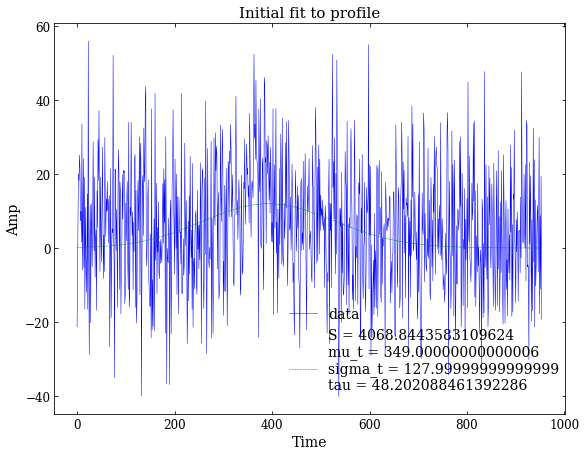

In [171]:
plot = True
profile_bounds=[]#((0, 0, 0, -np.inf),(np.inf, np.inf, np.inf, np.inf)) # did not work when only set up bounds but do not chop data 
bf.initial_profilefit(plot=plot, bounds=profile_bounds)

### Spectra Fit

In [172]:
bf.make_spectra()

2021-11-11 23:53:53,141 - make_spectra -burstfit.fit - INFO - Making spectra using profile fit parameters.


2021-11-11 23:53:54,067 - initial_spectrafit -burstfit.fit - INFO - Running spectra profile fit for component: 1
2021-11-11 23:53:54,084 - initial_spectrafit -burstfit.fit - INFO - Converged parameters (spectra fit) are:
2021-11-11 23:53:54,085 - initial_spectrafit -burstfit.fit - INFO - mu_f: 103.2421464890175 +- 6.8370004703108265
2021-11-11 23:53:54,086 - initial_spectrafit -burstfit.fit - INFO - sigma_f: 49.43607761224164 +- 5.651347359669218


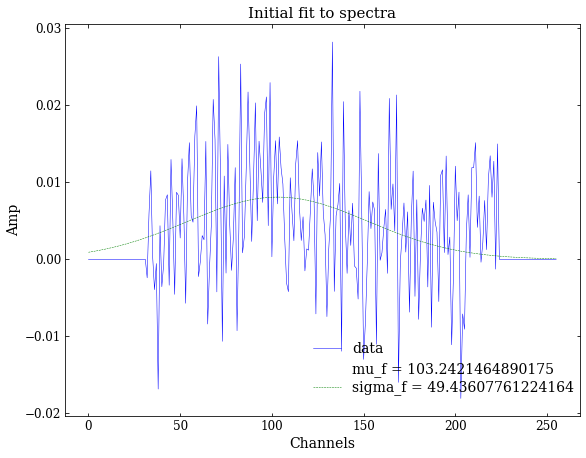

In [173]:
bf.initial_spectrafit(plot=plot)

Let's look at the profile and spectra fit parameters we just obtained 
(these were also printed in the logs above)

In [174]:
bf.profile_params

{1: {'popt': [4068.8443583109624,
   349.00000000000006,
   127.99999999999999,
   48.202088461392286],
  'perr': array([447.13781342, 136.88123417,  47.52048343, 159.48865297])}}

In [175]:
bf.spectra_params

{1: {'popt': [103.2421464890175, 49.43607761224164],
  'perr': array([6.83700047, 5.65134736])}}

Now the above parameters will be used as initial guess to do sgram fitting. 

### Spectrogram Fit

2021-11-11 23:53:59,414 - sgram_fit -burstfit.fit - INFO - Running sgram profile fit for component: 1
2021-11-11 23:53:59,416 - sgram_fit -burstfit.fit - INFO - initial estimate for parameters: [103.2421464890175, 49.43607761224164, 4068.8443583109624, 349.00000000000006, 127.99999999999999, 48.202088461392286, 59.4]
2021-11-11 23:54:00,759 - sgram_fit -burstfit.fit - INFO - Converged parameters are:
2021-11-11 23:54:00,760 - sgram_fit -burstfit.fit - INFO - mu_f: 104.21419975791768 +- 4.61348059701604
2021-11-11 23:54:00,761 - sgram_fit -burstfit.fit - INFO - sigma_f: 46.87990103404609 +- 4.6969826993418975
2021-11-11 23:54:00,761 - sgram_fit -burstfit.fit - INFO - S: 5658.829167354868 +- 634.5263679600497
2021-11-11 23:54:00,762 - sgram_fit -burstfit.fit - INFO - mu_t: 300.6458134377403 +- 152.62336280200114
2021-11-11 23:54:00,763 - sgram_fit -burstfit.fit - INFO - sigma_t: 216.60952284579182 +- 76.78731043305959
2021-11-11 23:54:00,764 - sgram_fit -burstfit.fit - INFO - tau: 138.95

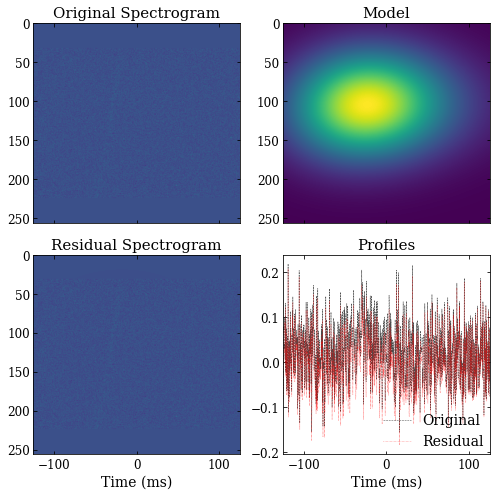

2021-11-11 23:54:01,495 - model -burstfit.fit - INFO - Making model.
2021-11-11 23:54:01,496 - model -burstfit.fit - INFO - Found 1 components.


In [176]:
bf.sgram_fit(plot=plot)

We can see the reduced chi square value of our sgram_fit too

In [177]:
bf.calc_redchisq()

2021-11-11 23:54:07,158 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2021-11-11 23:54:07,160 - get_off_pulse_region -burstfit.fit - INFO - Using sgram fit parameters.
/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/numpy/core/_methods.py:224: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
2021-11-11 23:54:07,178 - model -burstfit.fit - INFO - Making model.
2021-11-11 23:54:07,179 - model -burstfit.fit - INFO - Found 1 components.
2021-11-11 23:54:07,211 - calc_redchisq -b

masked

The fit parameters can be accessed using bf.sgram_params. It shows only one component as we only did one component fitting.

In [178]:
bf.sgram_params

{1: {'popt': [104.21419975791768,
   46.87990103404609,
   5658.829167354868,
   300.6458134377403,
   216.60952284579182,
   138.95815965461938,
   -71.32076157559591],
  'perr': array([  4.6134806 ,   4.6969827 , 634.52636796, 152.6233628 ,
          76.78731043, 186.77750726, 340.48980205])}}

## fitcycle()

All the above steps have also been wrapped with fitcycle() 

2021-11-11 23:54:10,021 - fitcycle -burstfit.fit - INFO - Fitting component 1.
2021-11-11 23:54:10,024 - initial_profilefit -burstfit.fit - INFO - Running initial profile fit for component: 1
2021-11-11 23:54:10,057 - initial_profilefit -burstfit.fit - INFO - Converged parameters (profile fit) are:
2021-11-11 23:54:10,058 - initial_profilefit -burstfit.fit - INFO - S: 4068.8443583109624 +- 447.1378134227034
2021-11-11 23:54:10,059 - initial_profilefit -burstfit.fit - INFO - mu_t: 349.00000000000006 +- 136.88123417323115
2021-11-11 23:54:10,060 - initial_profilefit -burstfit.fit - INFO - sigma_t: 127.99999999999999 +- 47.52048342895066
2021-11-11 23:54:10,061 - initial_profilefit -burstfit.fit - INFO - tau: 48.202088461392286 +- 159.48865297146054


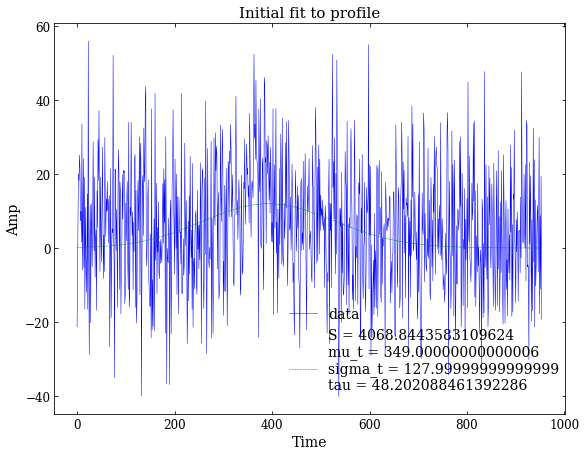

2021-11-11 23:54:10,303 - make_spectra -burstfit.fit - INFO - Making spectra using profile fit parameters.
2021-11-11 23:54:10,305 - initial_spectrafit -burstfit.fit - INFO - Running spectra profile fit for component: 1
2021-11-11 23:54:10,315 - initial_spectrafit -burstfit.fit - INFO - Converged parameters (spectra fit) are:
2021-11-11 23:54:10,316 - initial_spectrafit -burstfit.fit - INFO - mu_f: 103.2421464890175 +- 6.8370004703108265
2021-11-11 23:54:10,317 - initial_spectrafit -burstfit.fit - INFO - sigma_f: 49.43607761224164 +- 5.651347359669218


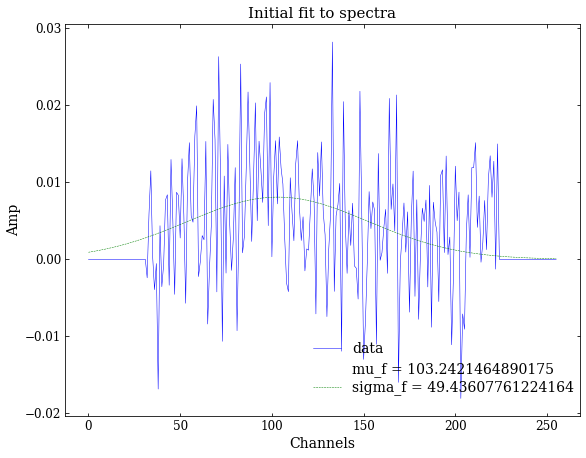

2021-11-11 23:54:10,534 - sgram_fit -burstfit.fit - INFO - Running sgram profile fit for component: 1
2021-11-11 23:54:10,535 - sgram_fit -burstfit.fit - INFO - initial estimate for parameters: [103.2421464890175, 49.43607761224164, 4068.8443583109624, 349.00000000000006, 127.99999999999999, 48.202088461392286, 59.4]
2021-11-11 23:54:11,829 - sgram_fit -burstfit.fit - INFO - Converged parameters are:
2021-11-11 23:54:11,831 - sgram_fit -burstfit.fit - INFO - mu_f: 104.21419975791768 +- 4.61348059701604
2021-11-11 23:54:11,832 - sgram_fit -burstfit.fit - INFO - sigma_f: 46.87990103404609 +- 4.6969826993418975
2021-11-11 23:54:11,832 - sgram_fit -burstfit.fit - INFO - S: 5658.829167354868 +- 634.5263679600497
2021-11-11 23:54:11,833 - sgram_fit -burstfit.fit - INFO - mu_t: 300.6458134377403 +- 152.62336280200114
2021-11-11 23:54:11,834 - sgram_fit -burstfit.fit - INFO - sigma_t: 216.60952284579182 +- 76.78731043305959
2021-11-11 23:54:11,835 - sgram_fit -burstfit.fit - INFO - tau: 138.95

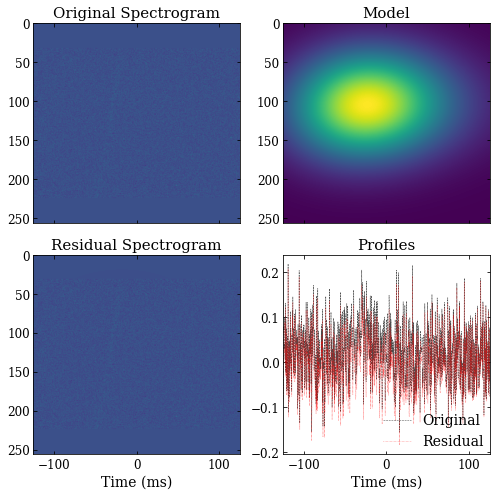

2021-11-11 23:54:12,381 - model -burstfit.fit - INFO - Making model.
2021-11-11 23:54:12,382 - model -burstfit.fit - INFO - Found 1 components.
2021-11-11 23:54:12,397 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2021-11-11 23:54:12,398 - get_off_pulse_region -burstfit.fit - INFO - Using sgram fit parameters.
/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/numpy/core/_methods.py:224: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
2021-11-11 23:54:12,404 - model -burstfit.

In [179]:
bf.fitcycle(plot=True) #profile_bounds=[450, 550]

## fitall()

But `fitcycle()` only fits for one component. `BurstFit` can automatically fit for multiple components as well. For that we will use `fitall()`

Here it calls `fitcycle()` to fit for a component and then compares the ON-pulse residual with the OFF pulse regions (both left and right). If the distributions are similar then fitting is terminated. If the distributions aren't similar, then it tries to fit for another component. In the end, it will fit for all the components together. 

2021-11-11 23:52:12,935 - run_tests -burstfit.fit - INFO - Running statistical tests on the residual.
2021-11-11 23:52:12,936 - run_tests -burstfit.fit - INFO - Running off pulse - off pulse test
2021-11-11 23:52:12,952 - tests -root - INFO - P values: T-test (0.00785), Kruskal (0.01287), KS (0.14138), F-test (0.99969)
2021-11-11 23:52:12,953 - run_tests -burstfit.fit - INFO - Running on pulse - off pulse (L) test
2021-11-11 23:52:12,963 - tests -root - INFO - P values: T-test (0.32092), Kruskal (0.62354), KS (0.76883), F-test (0.99393)
2021-11-11 23:52:12,964 - run_tests -burstfit.fit - INFO - On pulse residual is similar to left off pulse region.
2021-11-11 23:52:12,965 - run_tests -burstfit.fit - INFO - Running on pulse - off pulse (R) test
2021-11-11 23:52:12,979 - tests -root - INFO - P values: T-test (0.09316), Kruskal (0.04624), KS (0.06242), F-test (0.18009)
2021-11-11 23:52:12,980 - run_tests -burstfit.fit - INFO - On pulse residual is similar to right off pulse region.
2021-1

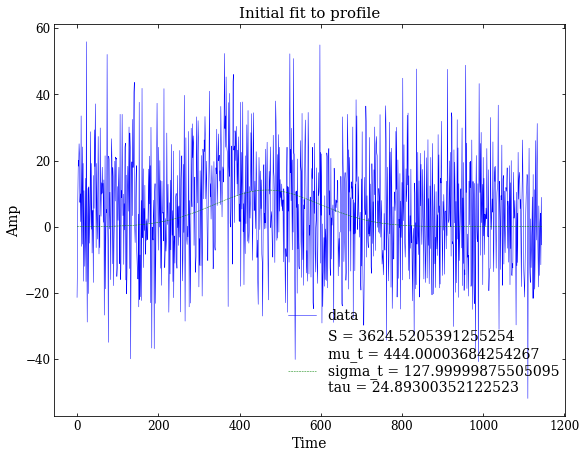

2021-11-11 23:52:13,227 - make_spectra -burstfit.fit - INFO - Making spectra using profile fit parameters.
2021-11-11 23:52:13,230 - initial_spectrafit -burstfit.fit - INFO - Running spectra profile fit for component: 1
2021-11-11 23:52:13,251 - initial_spectrafit -burstfit.fit - INFO - Converged parameters (spectra fit) are:
2021-11-11 23:52:13,253 - initial_spectrafit -burstfit.fit - INFO - mu_f: 103.48535825211701 +- 5.919920854994291
2021-11-11 23:52:13,254 - initial_spectrafit -burstfit.fit - INFO - sigma_f: 45.372107593055716 +- 4.870111565022926


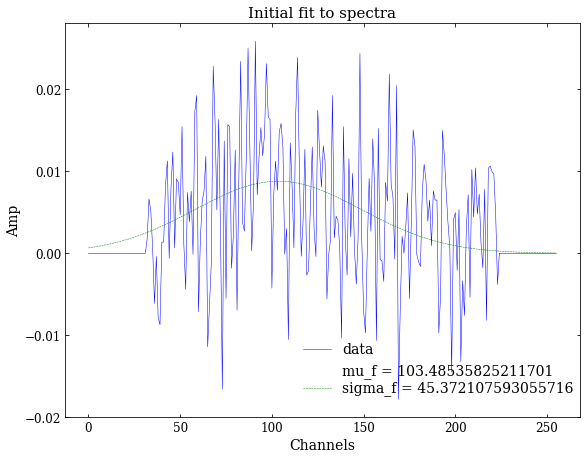

2021-11-11 23:52:13,465 - sgram_fit -burstfit.fit - INFO - Running sgram profile fit for component: 1
2021-11-11 23:52:13,466 - sgram_fit -burstfit.fit - INFO - initial estimate for parameters: [103.48535825211701, 45.372107593055716, 3624.5205391255254, 444.00003684254267, 127.99999875505095, 24.89300352122523, 59.4]
2021-11-11 23:52:14,521 - sgram_fit -burstfit.fit - INFO - Converged parameters are:
2021-11-11 23:52:14,523 - sgram_fit -burstfit.fit - INFO - mu_f: 100.68677342889951 +- 4.248272346779229
2021-11-11 23:52:14,524 - sgram_fit -burstfit.fit - INFO - sigma_f: 41.56895982115056 +- 4.291582016912138
2021-11-11 23:52:14,525 - sgram_fit -burstfit.fit - INFO - S: 3742.3539645385927 +- 332.87312139565086
2021-11-11 23:52:14,525 - sgram_fit -burstfit.fit - INFO - mu_t: 417.9969286170094 +- 4.379203744473535
2021-11-11 23:52:14,527 - sgram_fit -burstfit.fit - INFO - sigma_t: 136.9723195469681 +- 1.423399184209865
2021-11-11 23:52:14,527 - sgram_fit -burstfit.fit - INFO - tau: 24.80

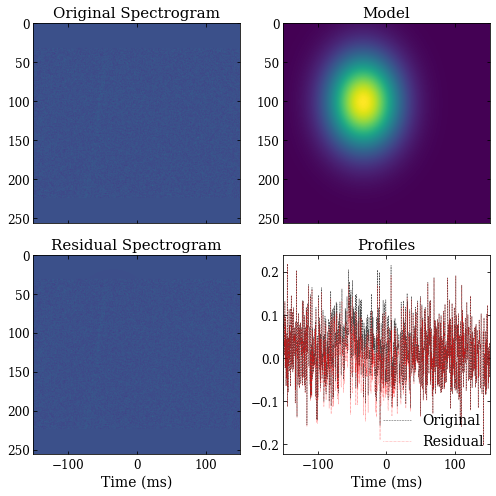

2021-11-11 23:52:15,113 - model -burstfit.fit - INFO - Making model.
2021-11-11 23:52:15,115 - model -burstfit.fit - INFO - Found 1 components.
2021-11-11 23:52:15,136 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2021-11-11 23:52:15,137 - get_off_pulse_region -burstfit.fit - INFO - Using sgram fit parameters.
2021-11-11 23:52:15,139 - model -burstfit.fit - INFO - Making model.
2021-11-11 23:52:15,140 - model -burstfit.fit - INFO - Found 1 components.
2021-11-11 23:52:15,173 - calc_redchisq -burstfit.fit - INFO - Reduced chi-square value of fit is: 0.9929583904503089
2021-11-11 23:52:15,175 - run_tests -burstfit.fit - INFO - Running statistical tests on the residual.
2021-11-11 23:52:15,175 - run_tests -burstfit.fit - INFO - Running off pulse - off pulse test
2021-11-11 23:52:15,190 - tests -root - INFO - P values: T-test (0.00785), Kruskal (0.01287), KS (0.14138), F-test (0.99969)
2021-11-11 23:52:15,191 - run

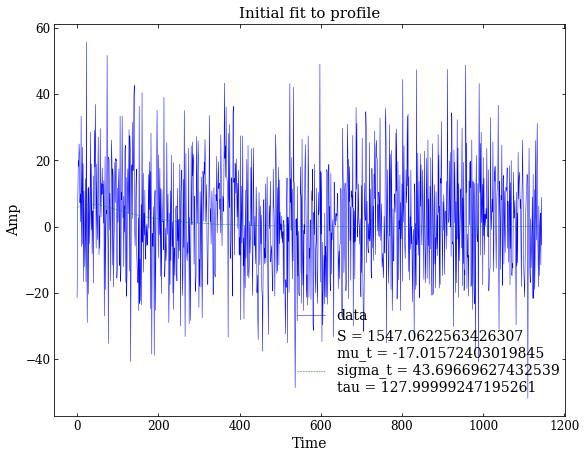

2021-11-11 23:52:15,491 - make_spectra -burstfit.fit - INFO - Making spectra using profile fit parameters.
2021-11-11 23:52:15,494 - initial_spectrafit -burstfit.fit - INFO - Running spectra profile fit for component: 2
2021-11-11 23:52:15,498 - initial_spectrafit -burstfit.fit - INFO - Converged parameters (spectra fit) are:
2021-11-11 23:52:15,499 - initial_spectrafit -burstfit.fit - INFO - mu_f: 134.3048537328138 +- 12.110660022416173
2021-11-11 23:52:15,500 - initial_spectrafit -burstfit.fit - INFO - sigma_f: 47.476960914376306 +- 9.930492201425448


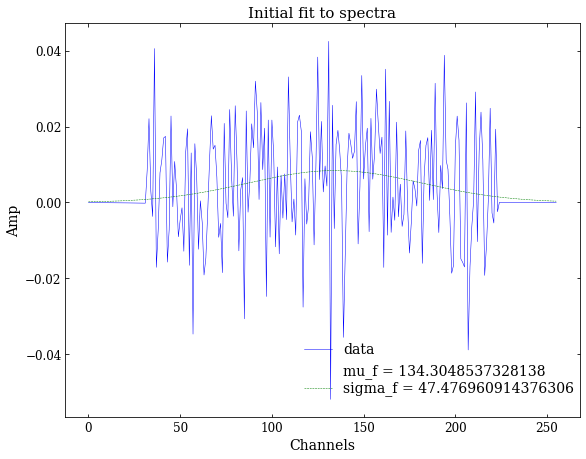

2021-11-11 23:52:15,672 - sgram_fit -burstfit.fit - INFO - Running sgram profile fit for component: 2
2021-11-11 23:52:15,673 - sgram_fit -burstfit.fit - INFO - initial estimate for parameters: [134.3048537328138, 47.476960914376306, 1547.0622563426307, -17.01572403019845, 43.69669627432539, 127.99999247195261, 59.4]
2021-11-11 23:52:17,885 - sgram_fit -burstfit.fit - INFO - Converged parameters are:
2021-11-11 23:52:17,887 - sgram_fit -burstfit.fit - INFO - mu_f: 144.49428866610813 +- 29.21945056742117
2021-11-11 23:52:17,888 - sgram_fit -burstfit.fit - INFO - sigma_f: 69.72870879405289 +- 24.855937566874474
2021-11-11 23:52:17,889 - sgram_fit -burstfit.fit - INFO - S: 1512.6680225215646 +- 546.0097067382138
2021-11-11 23:52:17,890 - sgram_fit -burstfit.fit - INFO - mu_t: 174.87819363637527 +- 12.488236526063925
2021-11-11 23:52:17,890 - sgram_fit -burstfit.fit - INFO - sigma_t: 6.10898315236771 +- 5.007505405203905
2021-11-11 23:52:17,891 - sgram_fit -burstfit.fit - INFO - tau: 44.51

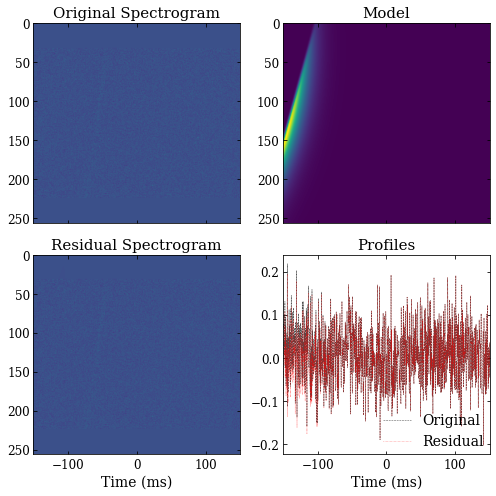

2021-11-11 23:52:18,445 - model -burstfit.fit - INFO - Making model.
2021-11-11 23:52:18,447 - model -burstfit.fit - INFO - Found 2 components.
2021-11-11 23:52:18,477 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2021-11-11 23:52:18,478 - get_off_pulse_region -burstfit.fit - INFO - Using sgram fit parameters.
2021-11-11 23:52:18,479 - model -burstfit.fit - INFO - Making model.
2021-11-11 23:52:18,480 - model -burstfit.fit - INFO - Found 2 components.
2021-11-11 23:52:18,522 - calc_redchisq -burstfit.fit - INFO - Reduced chi-square value of fit is: 1.0006960909972713
2021-11-11 23:52:18,523 - run_tests -burstfit.fit - INFO - Running statistical tests on the residual.
2021-11-11 23:52:18,524 - run_tests -burstfit.fit - INFO - Running off pulse - off pulse test
2021-11-11 23:52:18,534 - tests -root - INFO - P values: T-test (0.00785), Kruskal (0.01287), KS (0.14138), F-test (0.99969)
2021-11-11 23:52:18,535 - run

ValueError: Data passed to ks_2samp must not be empty

In [164]:
bf.fitall(plot=True)

The logging above shows the results of the statistical tests performed to compare the ON pulse residual with OFF pulse regions. Both the Left and Right off pulse regions were found to be statistically similar to ON pulse residual, and therefore the fitting was terminated. 

Again, the parameters can be accessed using `sgram_params`. The final parameters are saved in "all" key. This is useful in case of multiple components. In that case, individual component number will show the fit results for inidividual component, while "all" will give the result of fitting all the components together. In this case, we just had one component, so `fit_all_components` wasn't used, and therefore key "1" and "all" have same parameters. 

In [ ]:
bf.sgram_params['all']

## Plotting Results 

We can also plot the model, sgram and residuals

In [ ]:
plot_me(bf.sgram)

2021-11-11 21:12:04,784 - model -burstfit.fit - INFO - Making model.
2021-11-11 21:12:04,786 - model -burstfit.fit - INFO - Found 1 components.


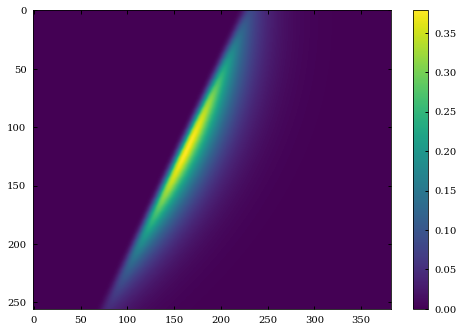

In [128]:
plot_me(bf.model)

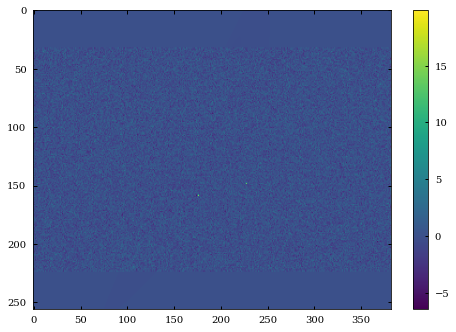

In [129]:
plot_me(bf.residual)

There are two ways of visualising plotting results using multi-panel plots. Using `plot_2d_fit` and `plot_fit_results`

In [130]:
from burstfit.utils.plotter import plot_2d_fit, plot_fit_results

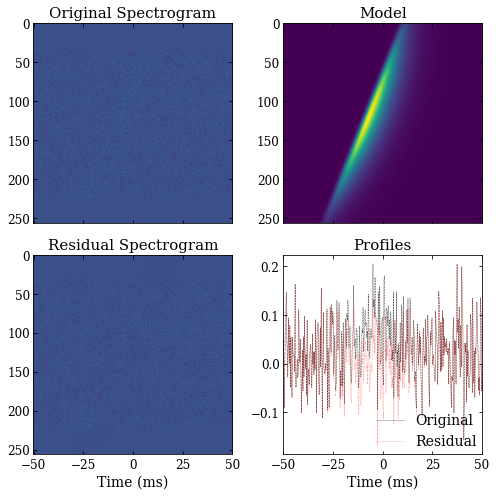

In [131]:
plot_2d_fit(bf.sgram, bf.sgram_model.evaluate, bf.sgram_params['all'][1]['popt'], 
            bf.tsamp, show=True, save=False)

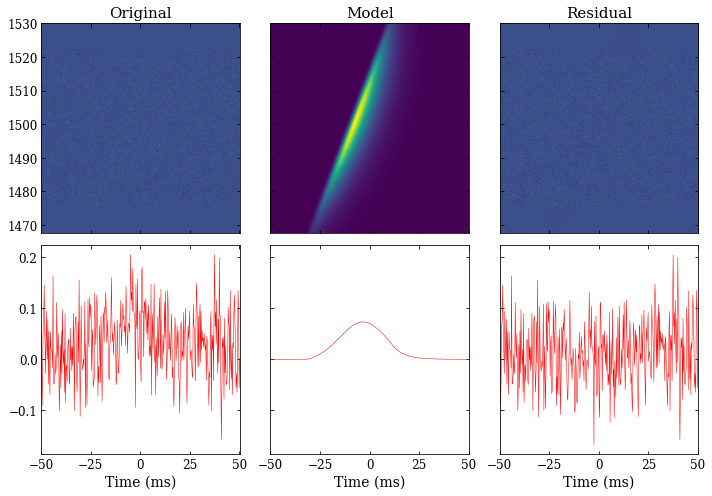

In [132]:
plot_fit_results(bf.sgram, bf.sgram_model.evaluate, bf.sgram_params['all'][1]['popt'], 
                 bf.tsamp, bf.fch1, bf.foff, show=True, save=False)

Now, to save the fitting results we can use `BurstIO` class. See this notebook.  